In [20]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import numpy as np
import cmocean.cm as ocm
from scipy.interpolate import griddata
from dask.distributed import Client

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
fig_dir  = os.path.join(proj_dir,'reports','tidal_melting','figures')
int_dir = os.path.join(data_dir,'interim')
raw_dir = os.path.join(data_dir,'raw')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from visualization.shiftedColorMap import shiftedColorMap
from roms_tools.cartesian_grid_2d import cartesian_grid_2d

tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)
from rotate_vector_roms import rotate_vector_roms
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves

In [21]:
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

file_path = os.path.join(data_dir,'raw','waom4','ocean_avg_0009_avg.nc')
tides = xr.open_dataset(file_path).squeeze()

file_path = os.path.join(data_dir,'raw','waom4_nt','ocean_avg_0009_avg.nc')
no_tides = xr.open_dataset(file_path).squeeze()

grd.mask_rho[570:610,1030:1140] = False

s2a = 365.25*24*3600

mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][1050:1140,95:113] = True

In [22]:
def make_uv_mag(u,v): 
    u_rho,v_rho = rotate_vector_roms(u.values,v.values,np.zeros_like(grd.mask_rho))
    return xr.DataArray(xr.ufuncs.sqrt(xr.ufuncs.square(u_rho)+xr.ufuncs.square(v_rho)),dims=('eta_rho','xi_rho'))

def get_vrange(da,vrange):
    if vrange==None:
        mean = da.mean(dim=da.dims)
        std = da.std(dim=da.dims)
        vmin=0-2*std
        vmax=0+2*std
    elif vrange=='sat':
        vmax = max(da.max(),np.abs(da.min()))
        vmin = -vmax
    else:
        vmax=vrange[1]
        vmin=vrange[0]

    return vmin,vmax

def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)


def plot_uv_map(ax,da,u,v,title,cbar_label,cmap,vrange=None,bl=5,grd=grd,cb_ext='both',save=False,
                mask_color=grd.mask_rho==1,mask_quiver=None,
                sel={'xi_rho':slice(72,1465),'eta_rho':slice(85,1300)}):  
    
    angle = np.zeros_like(grd.lon_rho.values)
    u_rho,v_rho = rotate_vector_roms(u.values, v.values, angle)
    
    u_rho = u_rho/(np.sqrt(u_rho**2 + v_rho**2))
    v_rho = v_rho/(np.sqrt(u_rho**2 + v_rho**2))
    
    u_rho[~mask_quiver]=np.nan
    v_rho[~mask_quiver]=np.nan
    
    if sel:
        da = da.where(mask_color).isel(sel)
        grd = grd.isel(sel)
        u_rho = u_rho[sel['eta_rho'],sel['xi_rho']]
        v_rho = v_rho[sel['eta_rho'],sel['xi_rho']]
        
    vmin,vmax = get_vrange(da,vrange)
    
    #plt.close()
    #fig,ax = plt.subplots(figsize=(8.27,9))
    ax.axis('off')
    ax.set_aspect('equal')
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))   
    cp = da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar=False)
    
    mask_ice = (grd.mask_rho==1) & (grd.zice<0)
    ax.contour(mask_ice, levels=['0.1'], colors=('black'),linewidths=0.5,linestyles='solid')
    ax.contour(grd.mask_rho,levels=['0.1'], colors=('black'),linewidths=0.1,linestyles='solid')
    
    cb = plt.colorbar(cp, ax=ax, pad=0.01, extend=cb_ext,orientation='horizontal')
    cb.set_label(label=cbar_label)
    
    quiverp = ax.quiver(np.arange(bl/2,grd.mask_rho.shape[1]+bl/2,bl),np.arange(bl/2,grd.mask_rho.shape[0]+bl/2,bl),
                        #rebin(u_rho.data,(grd.eta_rho.size//bl,grd.xi_rho.size//bl)),
                        #rebin(v_rho.data,(grd.eta_rho.size//bl,grd.xi_rho.size//bl)),
                        u_rho[1:grd.mask_rho.shape[0]:bl,1:grd.mask_rho.shape[1]:bl],
                        v_rho[1:grd.mask_rho.shape[0]:bl,1:grd.mask_rho.shape[1]:bl],
                        color='black')#,scale_units='x',scale=1,alpha=alpha)
    
    #plt.tight_layout()
    #if save:
    #    plt.savefig(os.path.join(fig_dir,title.replace('/','_')+'.png'),format='png',dpi=300,bbox_inches = "tight")
        
    #plt.show()
    return ax

In [46]:
def hcfnaive(a,b): 
    if(b==0): 
        return a 
    else: 
        return hcfnaive(b,a%b) 
  
print(hcfnaive(grd.eta_rho.size,grd.xi_rho.size)) 

25


In [130]:
uv_mag_tides = make_uv_mag(tides.ubar,tides.vbar)
mask_quiver = (mask_shelf['Total Antarctica']) & (uv_mag_tides*100 > 1)

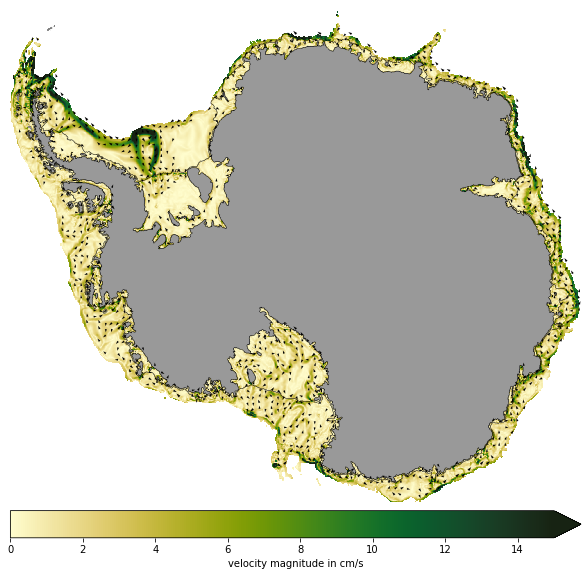

In [133]:
plot_uv_map(uv_mag_tides*100,tides.ubar*100,tides.vbar*100,'2d_currents','velocity magnitude in cm/s',
            ocm.speed,[0,15],15,save=False,
            cb_ext='max',mask_quiver=mask_quiver,mask_color=mask_shelf['Total Antarctica'])

In [74]:
u_tide = xr.open_dataarray(os.path.join(int_dir,'u_tide_4.nc'))
u_tide = u_tide.rename({'xi_rho':'eta_rho','eta_rho':'xi_rho'})

In [75]:
u_tide

<xarray.DataArray (eta_rho: 1325, xi_rho: 1575)>
[2086875 values with dtype=float64]
Dimensions without coordinates: eta_rho, xi_rho

In [23]:
def plot_map(ax,da,title,cbar_label,cmap,vrange=None,cb_ext='both',grd=grd,
             sel={'xi_rho':slice(72,1465),'eta_rho':slice(85,1300)},sb=False,secb=False,save=False):
    if sel:
        da = da.isel(sel)
        grd = grd.isel(sel)
        
    vmin,vmax = get_vrange(da,vrange)
    
    #plt.close()
    #fig,ax = plt.subplots(figsize=(8.27,9))
    ax.axis('off')
    ax.set_aspect('equal')
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))   
    cp = da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar=False)
    
    mask_ice = (grd.mask_rho==1) & (grd.zice<0)
    ax.contour(mask_ice, levels=['0.1'], colors=('black'),linewidths=0.5,linestyles='solid')
    ax.contour(grd.mask_rho,levels=['0.1'], colors=('black'),linewidths=0.1,linestyles='solid')
    
    cb = plt.colorbar(cp, ax=ax, pad=0.01, extend=cb_ext)
    cb.set_label(label=cbar_label)   
    ax.set_title("")
    #plt.tight_layout()
    #if save==True:
    #    plt.savefig(os.path.join(fig_dir,'map_'+title.replace('/','_')+'.png'),format='png',bbox_inches = "tight")
    #elif save=='hr':
    #    plt.savefig(os.path.join(fig_dir,'map_'+title.replace('/','_')+'.png'),format='png',dpi=400,bbox_inches = "tight")
    #plt.show()
    return ax

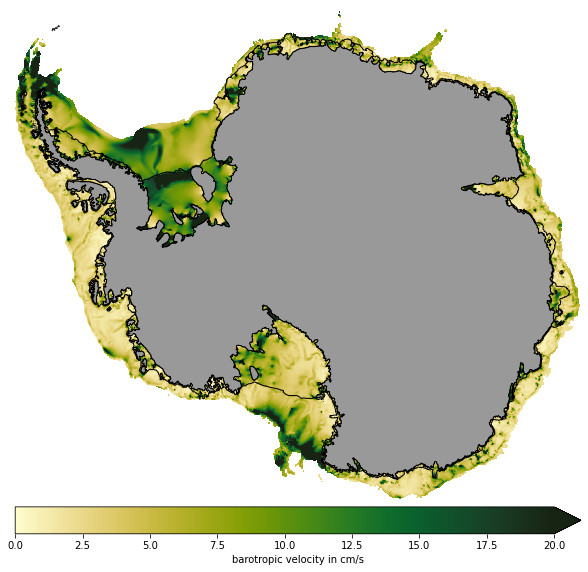

In [124]:
plot_map(u_tide.where(mask_shelf['Total Antarctica'])*100,'u_tide','barotropic velocity in cm/s',
            ocm.speed,[0,20],save=False,cb_ext='max')

In [97]:
u_diff = tides.ubar-no_tides.ubar
v_diff = tides.vbar-no_tides.vbar
uv_mag_noTides = make_uv_mag(no_tides.ubar,no_tides.vbar)
uv_mag_diff = uv_mag_tides-uv_mag_noTides 

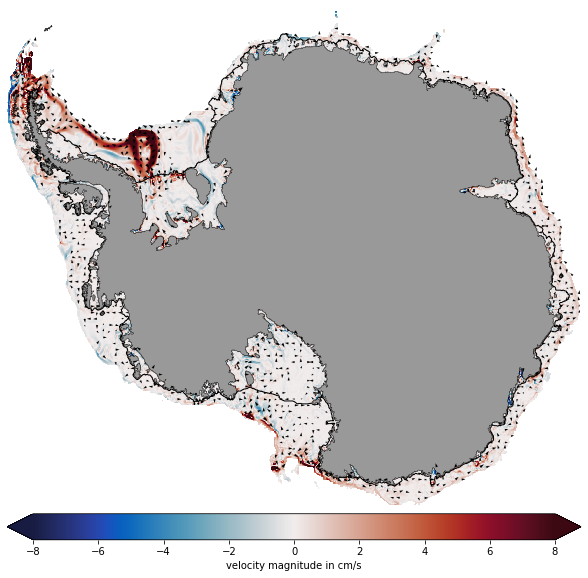

In [101]:
plot_uv_map(uv_mag_diff*100,u_diff*100,v_diff*100,'2d_currents','velocity magnitude in cm/s',
            ocm.balance,[-8,8],15,save=False,
            cb_ext='both',mask_quiver=mask,mask_color=mask_shelf['Total Antarctica'])

In [102]:
mask = (mask_shelf['Total Antarctica'] == 1) & (grd.mask_rho == 1)
dV = grd.dV.where(mask)
weights = dV/dV.sum('s_rho')
temp_t = (tides.temp*weights).sum('s_rho').where(mask)
temp_nt = (no_tides.temp*weights).sum('s_rho').where(mask)
temp_diff = temp_t - temp_nt

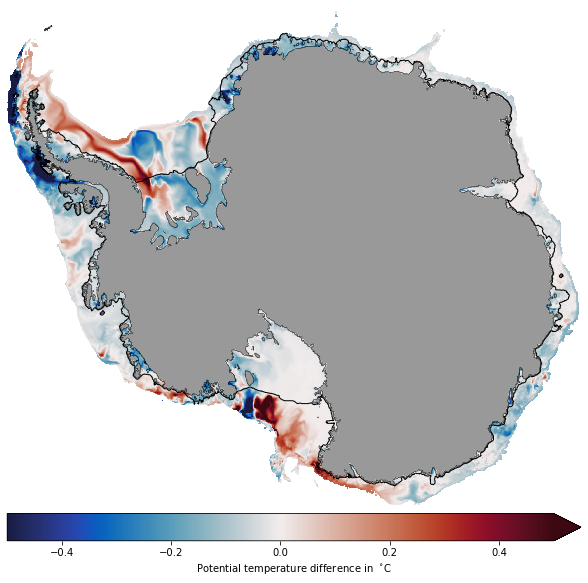

In [105]:
plot_map(temp_diff.where(mask_shelf['Total Antarctica']),'temp_diff','Potential temperature difference in  $^{\circ}$C',
            ocm.balance,[-0.5,0.5],save=False,cb_ext='max')

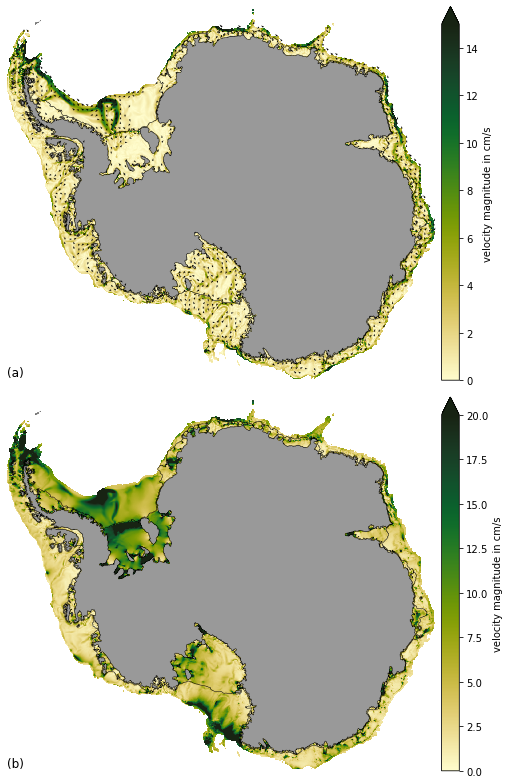

In [149]:
import string
fig,axes = plt.subplots(nrows=2,figsize=(8.27,11))

ax1,ax2 = axes.flatten()

ax1 = plot_uv_map(ax1,uv_mag_tides*100,tides.ubar*100,tides.vbar*100,'2d_currents','velocity magnitude in cm/s',
            ocm.speed,[0,15],15,save=False,
            cb_ext='max',mask_quiver=mask_quiver,mask_color=mask_shelf['Total Antarctica'])

ax2 = plot_map(ax2,u_tide.where(mask_shelf['Total Antarctica'])*100,'u_tide','velocity magnitude in cm/s',
            ocm.speed,[0,20],save=False,cb_ext='max')

for n,ax in enumerate([ax1,ax2]):
    ax.text(0.0, 0.01, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, size=12)

plt.tight_layout()

out_path = os.path.join(fig_dir,'velocities.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

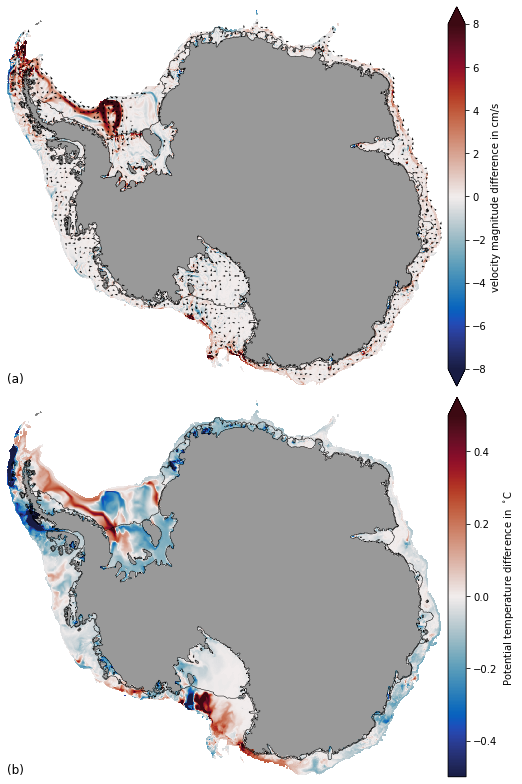

In [152]:
import string
fig,axes = plt.subplots(nrows=2,figsize=(8.27,11))

ax1,ax2 = axes.flatten()

ax1 = plot_uv_map(ax1,uv_mag_diff*100,u_diff*100,v_diff*100,'2d_currents','velocity magnitude difference in cm/s',
            ocm.balance,[-8,8],15,save=False,
            cb_ext='both',mask_quiver=mask_quiver,mask_color=mask_shelf['Total Antarctica'])

ax2 = plot_map(ax2,temp_diff.where(mask_shelf['Total Antarctica']),'temp_diff','Potential temperature difference in  $^{\circ}$C',
            ocm.balance,[-0.5,0.5],save=False,cb_ext='max')

for n,ax in enumerate([ax1,ax2]):
    ax.text(0.0, 0.01, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, size=12)

plt.tight_layout()

out_path = os.path.join(fig_dir,'tidal_change_velocities_temp.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

In [159]:
AP_sel = {'xi_rho':slice(0,200),'eta_rho':slice(1000,1200)}
SC_sel = {'xi_rho':slice(1200,1400),'eta_rho':slice(900,1100)}

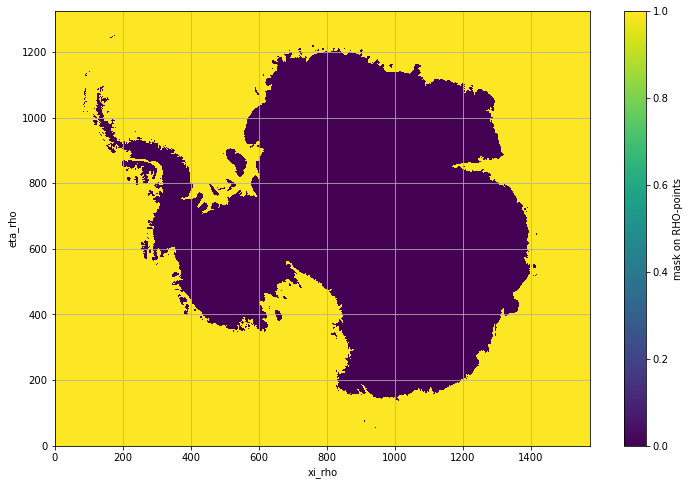

In [153]:
grd.mask_rho.plot(size=8)
plt.grid()

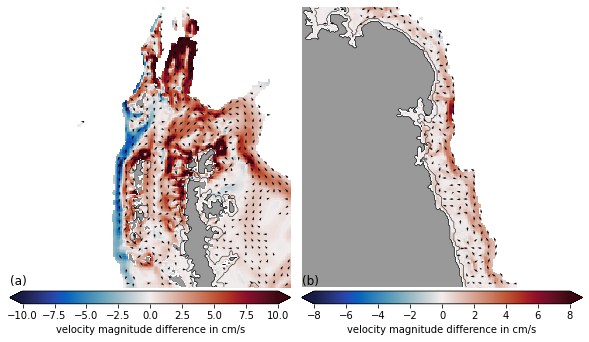

In [171]:
import string
fig,axes = plt.subplots(ncols=2,figsize=(8.27,5))

ax1,ax2 = axes.flatten()

ax1 = plot_uv_map(ax1,uv_mag_diff*100,u_diff*100,v_diff*100,'2d_currents','velocity magnitude difference in cm/s',
            ocm.balance,[-10,10],5,save=False,sel=AP_sel,
            cb_ext='both',mask_quiver=mask_quiver,mask_color=mask_shelf['Total Antarctica'])

ax2 = plot_uv_map(ax2,uv_mag_diff*100,u_diff*100,v_diff*100,'2d_currents','velocity magnitude difference in cm/s',
            ocm.balance,[-8,8],5,save=False,sel=SC_sel,
            cb_ext='both',mask_quiver=mask_quiver,mask_color=mask_shelf['Total Antarctica'])

for n,ax in enumerate([ax1,ax2]):
    ax.text(0.0, 0.01, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, size=12)

plt.tight_layout()

out_path = os.path.join(fig_dir,'tidal_change_velocities_zoom_ins.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

In [18]:
import pickle
pickle_in = open(os.path.join(int_dir,"var_tides2.pkl"),"rb")
var = pickle.load(pickle_in)

In [25]:
mask = (mask_shelf['Total Antarctica']) &(grd.zice<0)

In [36]:
sel_Amery = {'xi_rho':slice(1169,1325),'eta_rho':slice(780,920)}
sel_Ronne = {'xi_rho':slice(360,550),'eta_rho':slice(700,900)}

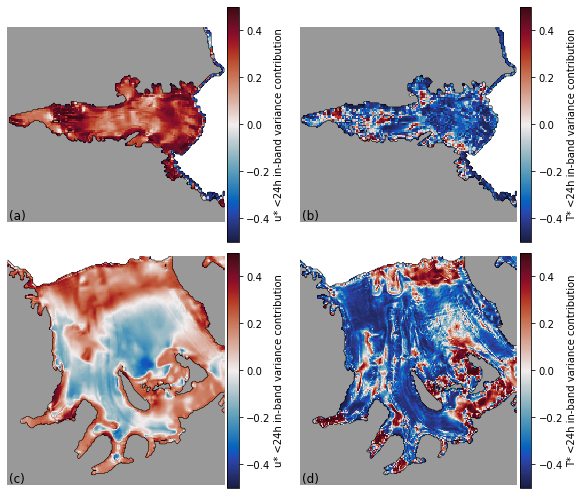

In [42]:
import string
fig,axes = plt.subplots(2,2,figsize=(8.27,7.0))

ax1,ax2,ax3,ax4 = axes.flatten()

ax1 = plot_map(ax1,var['tides']['ustar'].fast_contr.where(mask)-0.5,
               'ustar_var_contr','u* <24h in-band variance contribution',
               ocm.balance,'sat',cb_ext='neither',sel=sel_Amery)

ax2 = plot_map(ax2,var['tides']['Tstar'].fast_contr.where(mask)-0.5,
               'Tstar_var_contr','T* <24h in-band variance contribution',
               ocm.balance,'sat',cb_ext='neither',sel=sel_Amery)

ax3 = plot_map(ax3,var['tides']['ustar'].fast_contr.where(mask)-0.5,
               'ustar_var_contr','u* <24h in-band variance contribution',
               ocm.balance,'sat',cb_ext='neither',sel=sel_Ronne)

ax4 = plot_map(ax4,var['tides']['Tstar'].fast_contr.where(mask)-0.5,
               'Tstar_var_contr','T* <24h in-band variance contribution',
               ocm.balance,'sat',cb_ext='neither',sel=sel_Ronne)

for n,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.text(0.01, 0.01, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, size=12)

plt.tight_layout()

out_path = os.path.join(fig_dir,'Tstarustar_varcon_details.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()